The last notebook had too much -- this one is devoted to an exploration of matplot lib and some attempts to put together functions to be used later on

In [1]:
from fastai.vision.all import *
import matplotlib.pyplot as plt
import seaborn as sns
from pydicom import dcmread
%matplotlib inline

In [4]:
path = Path('/home/azaidi/Desktop/fastai/nbs/kaggle/osic')
Path.BASE_PATH = path
path.ls()

(#6) [Path('test.csv'),Path('train'),Path('train.csv'),Path('test'),Path('osic-pulmonary-fibrosis-progression.zip'),Path('sample_submission.csv')]

In [5]:
train_path = path/'train'
test_path = path/'test'
train_df = pd.read_csv(path/'train.csv')
test_df = pd.read_csv(path/'test.csv')
sample_sub = pd.read_csv(path/'sample_submission.csv')

In [6]:
#returns a list with the dicoms in order
def dcm_sort(patient_folder):
    #list comprehension that runs through folder of dicoms
    dcm_stacked = [dcmread(dcm) for dcm in patient_folder.ls()]
    dcm_stacked.sort(key=lambda x: int(x.InstanceNumber), reverse=True)
    #returning a python list of dicoms sorted
    return dcm_stacked

#transforms all slices in a scan in hounsfield units 
def ct_transformed_hu(dcm_sorted, threshold=-1000, replace=-1000):
    intercept = dcm_sorted[0].RescaleIntercept
    slices_stacked = np.stack([dcm.pixel_array for dcm in dcm_sorted])
    slices_stacked = slices_stacked.astype(np.int16)
    
    #converts the unknown values to desired replacement
    slices_stacked[slices_stacked <= threshold] = replace
    
    #turn into hounsfield scale
    slices_stacked += np.int16(intercept)
    
    return np.array(slices_stacked, dtype=np.int16)

In [7]:
#transforms all slices in a scan in hounsfield units 
def ct_transformed(dcm_sorted, threshold=-1000, replace=-1000):
    intercept = dcm_sorted[0].RescaleIntercept
    slices_stacked = np.stack([dcm.pixel_array for dcm in dcm_sorted])
    slices_stacked = slices_stacked.astype(np.int16)
    
    #converts the unknown values to desired replacement
    slices_stacked[slices_stacked <= threshold] = replace
    
    #turn into hounsfield scale
    slices_stacked += np.int16(intercept)
    
    return np.array(slices_stacked, dtype=np.int16)

In [8]:
%%time
scans = [dcm_sort(folder) for folder in train_path.ls()]

CPU times: user 18.6 s, sys: 11.9 s, total: 30.6 s
Wall time: 43.1 s


In [9]:
%%time
holder = []
for dcms in scans:
    slice_count = len(dcms)
    dcm = dcms[0]
    pat = train_df[train_df['Patient'] == dcm.PatientID].iloc[0]
    holder.append([pat['Patient'], pat['Age'], pat['Sex'],
                   pat['SmokingStatus'], slice_count, dcm.Rows, 
                   dcm.Columns, dcm.SliceThickness, 
                   dcm.PixelSpacing[0], dcm.PixelSpacing[1], 
                   dcm.Manufacturer, dcm.KVP, 
                   dcm.ConvolutionKernel,dcm.PatientPosition])
    
meta = pd.DataFrame(holder, columns=['patient', 'age',
                                         'sex', 'smoking_status',
                                'num_slices', 'rows', 'columns', 
                              'slice_thickness', 'spacing_x', 
                              'spacing_y', 'manufacturer',
                            'kvp', 'convolution_kernel',
                                        'patient_position'])

CPU times: user 79.8 ms, sys: 9.92 ms, total: 89.7 ms
Wall time: 101 ms


In [10]:
meta

,patient,age,sex,smoking_status,num_slices,rows,columns,slice_thickness,spacing_x,spacing_y,manufacturer,kvp,convolution_kernel,patient_position
0,ID00232637202260377586117,74,Female,Never smoked,67,512,512,5.000,0.683000,0.683000,TOSHIBA,120.0,FC52,FFS
1,ID00134637202223873059688,67,Male,Ex-smoker,451,512,512,1.000,0.740234,0.740234,Philips,120.0,YC,HFS
2,ID00093637202205278167493,69,Male,Ex-smoker,37,512,512,1.000,0.880859,0.880859,SIEMENS,120.0,B60f,FFS
3,ID00307637202282126172865,65,Male,Never smoked,29,512,512,1.000,0.707031,0.707031,SIEMENS,110.0,B90s,HFS
4,ID00364637202296074419422,64,Male,Ex-smoker,33,512,512,1.000,0.712891,0.712891,SIEMENS,100.0,B50f,HFS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,ID00336637202286801879145,56,Male,Ex-smoker,33,512,512,1.000,0.650391,0.650391,SIEMENS,120.0,B70s,FFP
172,ID00383637202300493233675,64,Female,Never smoked,32,512,512,1.000,0.656250,0.656250,SIEMENS,120.0,B50f,HFS
173,ID00067637202189903532242,64,Male,Ex-smoker,319,733,888,1.250,0.871094,0.871094,GE MEDICAL SYSTEMS,120.0,LUNG,FFS
174,ID00317637202283194142136,64,Male,Ex-smoker,521,512,512,0.625,0.677734,0.677734,GE MEDICAL SYSTEMS,120.0,LUNG,FFS


In [11]:
meta.shape

(176, 14)

In [12]:
def scatter_plot(x_val, y_val, alpha=None, title=None,
                x_label=None, y_label=None, color=None):
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.scatter(x_val, y_val, alpha=alpha, c=color)

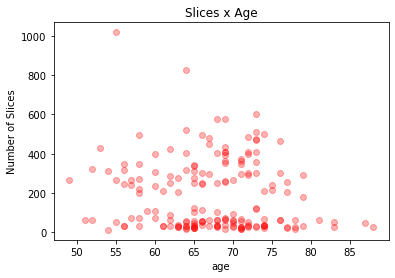

In [13]:
scatter_plot(meta['age'], meta['num_slices'], x_label='age',
            y_label='Number of Slices', title='Slices x Age',
            color='Red', alpha=0.3)

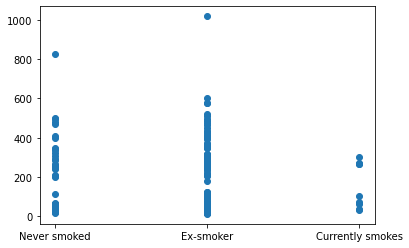

In [14]:
scatter_plot(meta['smoking_status'], meta['num_slices'])

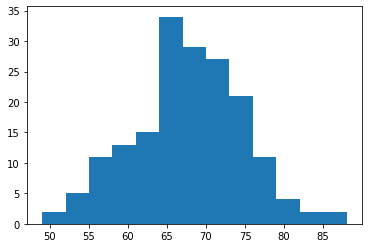

In [15]:
plt.hist(meta['age'], bins='auto', );#density=True);

In [16]:
meta['age'].unique()

array([74, 67, 69, 65, 64, 73, 70, 66, 55, 78, 60, 63, 71, 68, 79, 61, 58,
       81, 53, 72, 77, 51, 54, 62, 83, 56, 59, 75, 52, 57, 76, 49, 87, 88])

Seaborn has a cool heatmap to use: https://seaborn.pydata.org/examples/spreadsheet_heatmap.html

We'll feed this a correlation matrix -- pairwise correlation of columns: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html

In [17]:
meta.corr()

,age,num_slices,rows,columns,slice_thickness,spacing_x,spacing_y,kvp
age,1.000000,-0.117859,-0.009105,-0.039026,-0.007130,-0.118770,-0.118770,0.050420
num_slices,-0.117859,1.000000,0.009601,0.002078,-0.309427,0.025499,0.025499,-0.099925
rows,-0.009105,0.009601,1.000000,0.976386,-0.185585,-0.651788,-0.651788,-0.017598
columns,-0.039026,0.002078,0.976386,1.000000,-0.190254,-0.616842,-0.616842,-0.020463
slice_thickness,-0.007130,-0.309427,-0.185585,-0.190254,1.000000,0.141168,0.141168,0.110567
spacing_x,-0.118770,0.025499,-0.651788,-0.616842,0.141168,1.000000,1.000000,-0.046527
spacing_y,-0.118770,0.025499,-0.651788,-0.616842,0.141168,1.000000,1.000000,-0.046527
kvp,0.050420,-0.099925,-0.017598,-0.020463,0.110567,-0.046527,-0.046527,1.000000


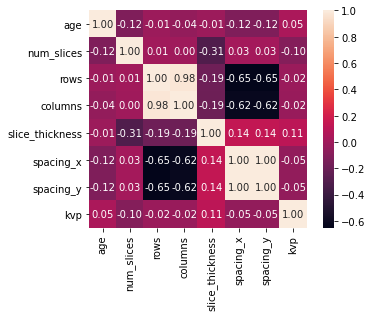

In [18]:
sns.heatmap(meta.corr(method='pearson'), 
            fmt='.2f', square=True, annot=True);

Ok we can see that the rows by columns of the slices is negatively correlated with the pixel spacing(!) meaning as the pixel spacing increases, the rows/columns should descrease -- this adds some coherence, we would hope that is the case

The slice thickness and number of slices are also negatively correlated -- which makes sense, you would presume that the two should not track one another. aka if the slice thickness increases -- we wouldn't be expecting the number of slices to also increase

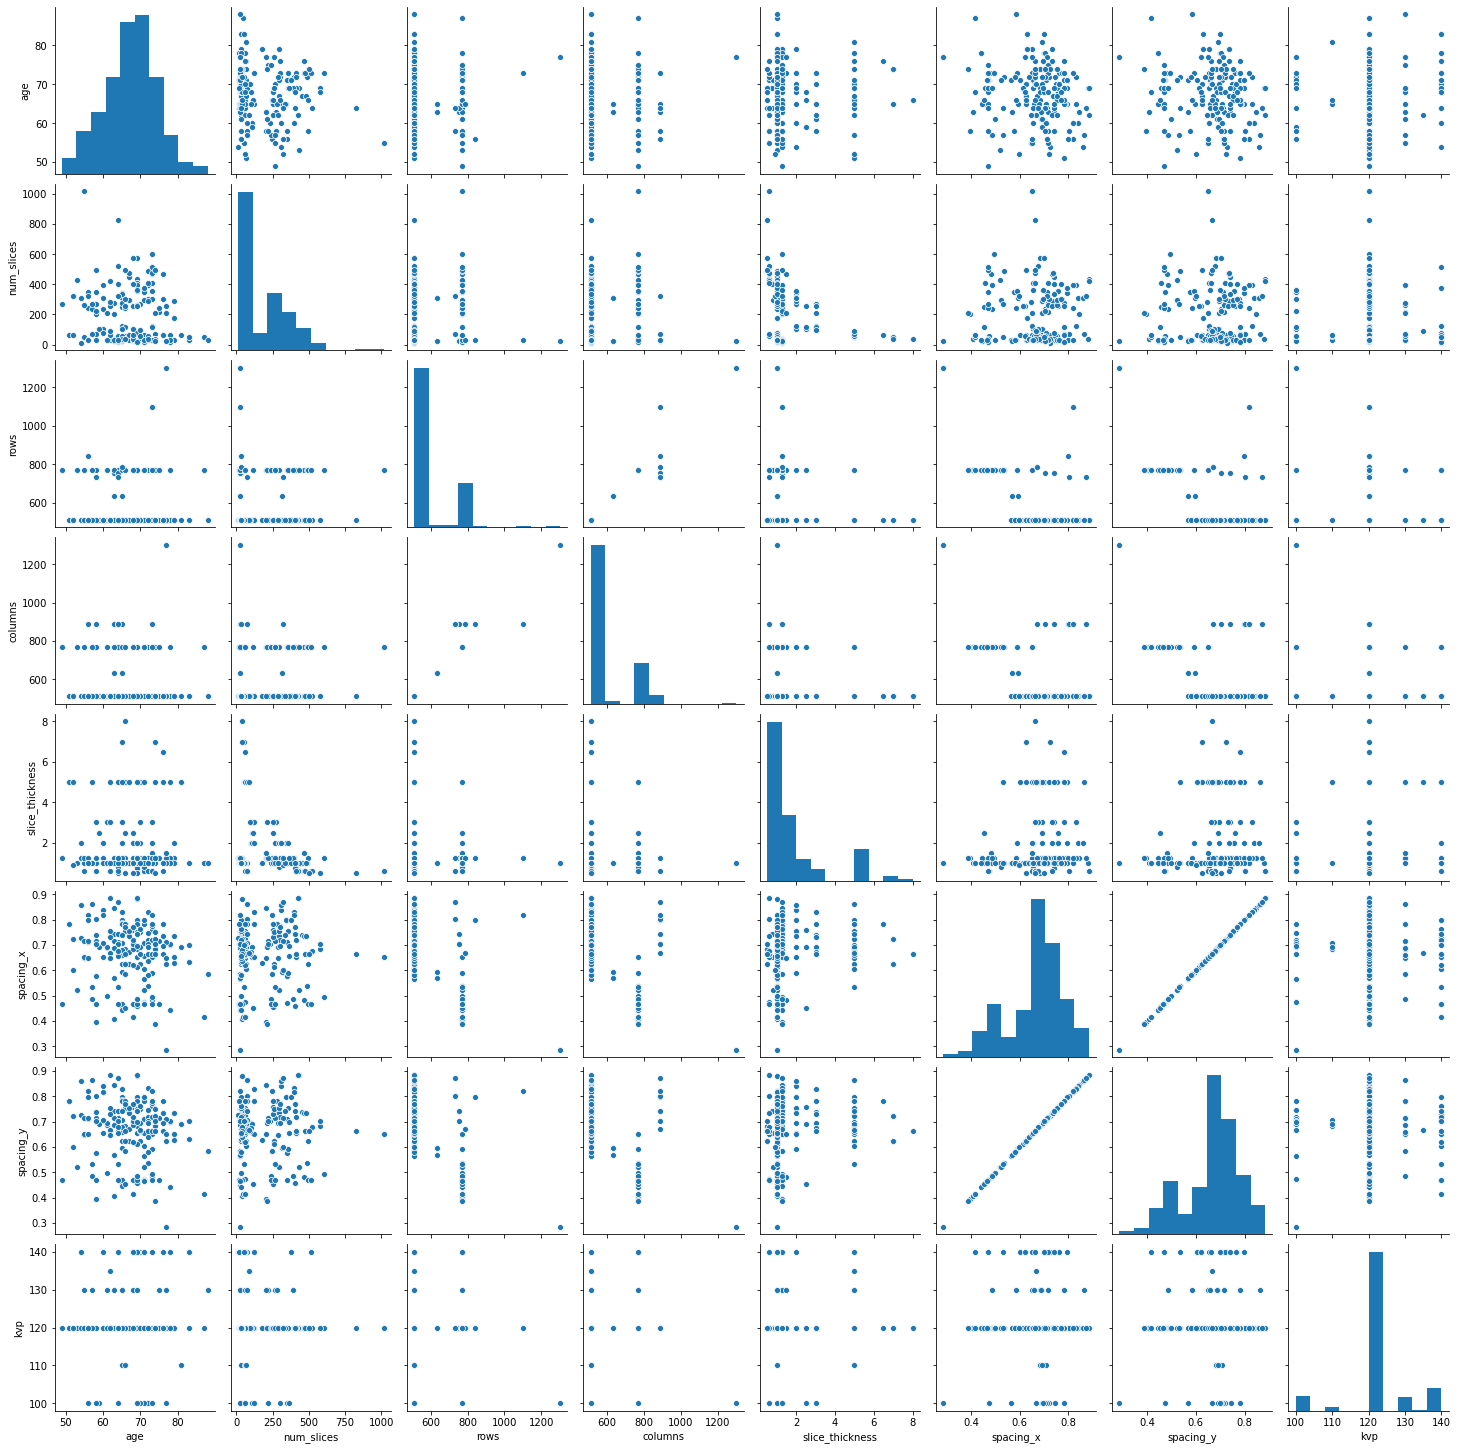

In [19]:
sns.pairplot(meta); #too many columns - let's pick interesting ones

In [20]:
list(meta.columns)

['patient',
 'age',
 'sex',
 'smoking_status',
 'num_slices',
 'rows',
 'columns',
 'slice_thickness',
 'spacing_x',
 'spacing_y',
 'manufacturer',
 'kvp',
 'convolution_kernel',
 'patient_position']

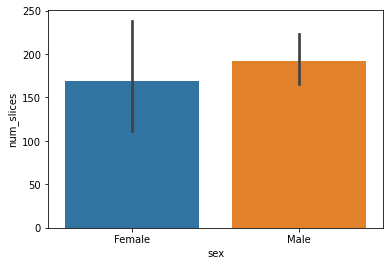

In [21]:
sns.barplot(x='sex', y='num_slices', data=meta);

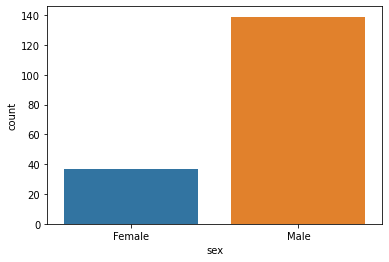

In [22]:
sns.countplot(x='sex', data=meta);

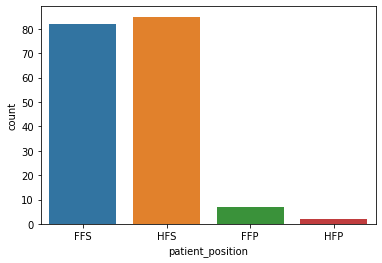

In [23]:
sns.countplot(x='patient_position', data=meta);

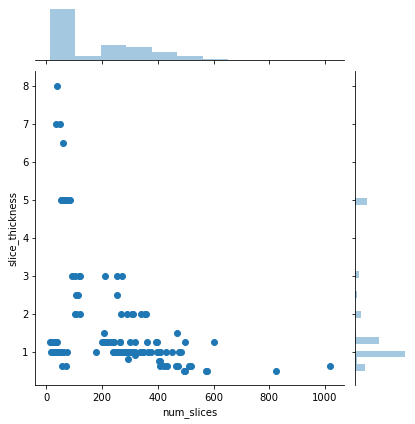

In [24]:
sns.jointplot(data=meta, x='num_slices', y='slice_thickness',
             )# hue='patient_position', kind='')

In [29]:
train_df

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker
...,...,...,...,...,...,...,...
1544,ID00426637202313170790466,13,2712,66.594637,73,Male,Never smoked
1545,ID00426637202313170790466,19,2978,73.126412,73,Male,Never smoked
1546,ID00426637202313170790466,31,2908,71.407524,73,Male,Never smoked
1547,ID00426637202313170790466,43,2975,73.052745,73,Male,Never smoked


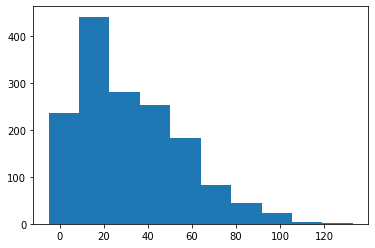

In [50]:
plt.hist(train_df['Weeks']);

In [49]:
train_df[['Patient','Weeks']].sort_values(by='Weeks')[0:12]

,Patient,Weeks
297,ID00086637202203494931510,-5
0,ID00007637202177411956430,-4
261,ID00076637202199015035026,-4
438,ID00122637202216437668965,-4
80,ID00023637202179104603099,-3
894,ID00233637202260580149633,-3
534,ID00133637202223847701934,-2
1230,ID00340637202287399835821,-1
323,ID00093637202205278167493,-1
175,ID00051637202185848464638,-1


In [57]:
sub_pat_wk = sample_sub['Patient_Week']
sub_pat_wk

0      ID00419637202311204720264_-12
1      ID00421637202311550012437_-12
2      ID00422637202311677017371_-12
3      ID00423637202312137826377_-12
4      ID00426637202313170790466_-12
                   ...              
725    ID00419637202311204720264_133
726    ID00421637202311550012437_133
727    ID00422637202311677017371_133
728    ID00423637202312137826377_133
729    ID00426637202313170790466_133
Name: Patient_Week, Length: 730, dtype: object

To pull just the patient info without the weeks or to seperate the two we can hardcode something or we can try with Regex. Should probably learn how to use regex, so let's quickly check that out

In [58]:
import re #pythons regex module

In [75]:
sub_pat_wk.str.len().value_counts()

28    495
29    185
27     50
Name: Patient_Week, dtype: int64

In [104]:
re.search('(ID[\d]*)', sub_pat_wk[0])

<re.Match object; span=(0, 25), match='ID00419637202311204720264'>

In [145]:
#nice(!!!!)
sub_pat_wk.str.findall('(ID[\d]*)')

0      [ID00419637202311204720264]
1      [ID00421637202311550012437]
2      [ID00422637202311677017371]
3      [ID00423637202312137826377]
4      [ID00426637202313170790466]
                  ...             
725    [ID00419637202311204720264]
726    [ID00421637202311550012437]
727    [ID00422637202311677017371]
728    [ID00423637202312137826377]
729    [ID00426637202313170790466]
Name: Patient_Week, Length: 730, dtype: object

In [184]:
#the extract fxn doesn't return a list bc we only want one
submission_wks = (sub_pat_wk.str.extract('_(-?\d*)')[0].astype(int))
submission_wks

0      -12
1      -12
2      -12
3      -12
4      -12
      ... 
725    133
726    133
727    133
728    133
729    133
Name: 0, Length: 730, dtype: int64

In [189]:
pct_neg = (submission_wks < 0).sum() / len(submission_wks)
print("{:.2f}% of the submission rows are for negative value weeks".format(pct_neg))

0.08% of the submission rows are for negative value weeks


In [191]:
#what's the issue with the find fxn...(???)
sub_pat_wk.str.find('_(-?[\d*])')

0     -1
1     -1
2     -1
3     -1
4     -1
      ..
725   -1
726   -1
727   -1
728   -1
729   -1
Name: Patient_Week, Length: 730, dtype: int64

Could use regex to create two new rows, one for the patient ID and the other for the number of weeks

In [195]:
sub_pat = sub_pat_wk.str.extract('(ID[\d]*)').astype(str)
sub_pat[0:2]

,0
0,ID00419637202311204720264
1,ID00421637202311550012437


In [201]:
sample_sub

,patient,Patient_Week,FVC,Confidence
0,ID00419637202311204720264,ID00419637202311204720264_-12,2000,100
1,ID00421637202311550012437,ID00421637202311550012437_-12,2000,100
2,ID00422637202311677017371,ID00422637202311677017371_-12,2000,100
3,ID00423637202312137826377,ID00423637202312137826377_-12,2000,100
4,ID00426637202313170790466,ID00426637202313170790466_-12,2000,100
...,...,...,...,...
725,ID00419637202311204720264,ID00419637202311204720264_133,2000,100
726,ID00421637202311550012437,ID00421637202311550012437_133,2000,100
727,ID00422637202311677017371,ID00422637202311677017371_133,2000,100
728,ID00423637202312137826377,ID00423637202312137826377_133,2000,100


Pandas insert to add the two columns and the drop fxn to remove the patient_week one

In [199]:
sample_sub.insert(0, 'patient', sub_pat)

In [200]:
sample_sub 

,patient,Patient_Week,FVC,Confidence
0,ID00419637202311204720264,ID00419637202311204720264_-12,2000,100
1,ID00421637202311550012437,ID00421637202311550012437_-12,2000,100
2,ID00422637202311677017371,ID00422637202311677017371_-12,2000,100
3,ID00423637202312137826377,ID00423637202312137826377_-12,2000,100
4,ID00426637202313170790466,ID00426637202313170790466_-12,2000,100
...,...,...,...,...
725,ID00419637202311204720264,ID00419637202311204720264_133,2000,100
726,ID00421637202311550012437,ID00421637202311550012437_133,2000,100
727,ID00422637202311677017371,ID00422637202311677017371_133,2000,100
728,ID00423637202312137826377,ID00423637202312137826377_133,2000,100


In [216]:
sample_sub.insert(1, 'week', submission_wks)

In [210]:
sample_sub = sample_sub.drop('Patient_Week', axis=1)

In [217]:
sample_sub

,patient,week,FVC,Confidence
0,ID00419637202311204720264,-12,2000,100
1,ID00421637202311550012437,-12,2000,100
2,ID00422637202311677017371,-12,2000,100
3,ID00423637202312137826377,-12,2000,100
4,ID00426637202313170790466,-12,2000,100
...,...,...,...,...
725,ID00419637202311204720264,133,2000,100
726,ID00421637202311550012437,133,2000,100
727,ID00422637202311677017371,133,2000,100
728,ID00423637202312137826377,133,2000,100


In [226]:
submission_patients = list(sample_sub['patient'].unique())
submission_patients

['ID00419637202311204720264',
 'ID00421637202311550012437',
 'ID00422637202311677017371',
 'ID00423637202312137826377',
 'ID00426637202313170790466']

In [227]:
test_df

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00419637202311204720264,6,3020,70.186855,73,Male,Ex-smoker
1,ID00421637202311550012437,15,2739,82.045291,68,Male,Ex-smoker
2,ID00422637202311677017371,6,1930,76.672493,73,Male,Ex-smoker
3,ID00423637202312137826377,17,3294,79.258903,72,Male,Ex-smoker
4,ID00426637202313170790466,0,2925,71.824968,73,Male,Never smoked


Ok we're given five scans of five different patients. They all have had their scans on different points in time and it looks like we need to predict an FVC value along with a confidence level for theoretical measurements at 3 months before (hypotehetical week number 0) and 2+ years of weeks out. 

So really the model needs to be able to project a progression or regression in FVC values and it's confidence should most likely decrease as a function of time --> if a model is doing a mediocre time at predicting something a year out, intuitively you would think it should degrade as it tries to predict things further out. But maybe the prediction function is better at predicting further out in time because it's catching onto certain patterns in the lungs themselves.

In [232]:
len(train_df['Patient'].unique())/ len(train_df['Patient'])

0.11362169141381537

In [240]:
len(train_path.ls()), train_df.shape[0]

(176, 1549)

In [241]:
1549 * 0.1136

175.96640000000002

In [248]:
sample_sub = sample_sub.rename(columns={'patient':'Patient', 'week':'Week'})

In [257]:
sample_sub = sample_sub.rename(columns={'Week': 'Weeks'})

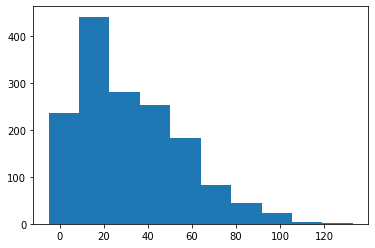

In [254]:
plt.hist(train_df['Weeks']);

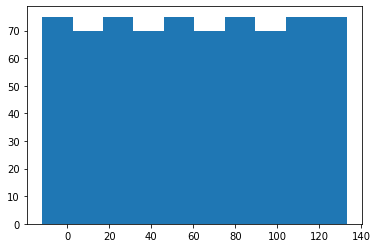

In [258]:
plt.hist(sample_sub['Weeks']);

So for all five of the patients in the test set we need to be able to provide predictions up to 140 weeks out (approaching 3 years).

Inside of the training data we're given, we really do not have much information on measurements beyond like 1.5 years....

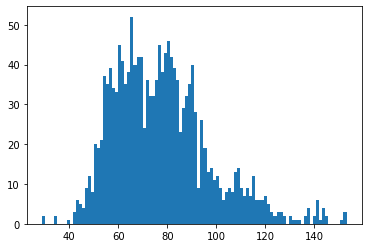

In [265]:
plt.hist(train_df['Percent'], bins=100);

And after reading the competition description further it's clear that you don't need to know what's going on in the test df nor the sample submission file, lovely :)